<a href="https://colab.research.google.com/github/yagoojoy/PINN_Taylor-Green-Vortex/blob/main/260114_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 0. 환경 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)

# 1. 데이터 생성 클래스 (동일)
class FluidGenerator:
    def __init__(self, L=4.0, nu=0.01):
        self.L, self.nu = L, nu
    def get_tgv_solution(self, X, Y, t):
        k = 1
        decay = np.exp(-2 * (k * np.pi)**2 * self.nu * t)
        u = -1.0 * np.cos(k * np.pi * X) * np.sin(k * np.pi * Y) * decay
        v =  1.0 * np.sin(k * np.pi * X) * np.cos(k * np.pi * Y) * decay
        p = -0.25 * (np.cos(2 * k * np.pi * X) + np.cos(2 * k * np.pi * Y)) * np.exp(-4 * (k * np.pi)**2 * self.nu * t)
        return u, v, p
    def get_unphysical_noise(self, X, Y, t):
        noise_scale = 0.05 * np.exp(-0.1 * t) # 노이즈 강도 소폭 조절
        u_n = noise_scale * np.sin(8 * np.pi * X / self.L) * np.sin(8 * np.pi * Y / self.L)
        v_n = noise_scale * np.cos(8 * np.pi * X / self.L) * np.cos(8 * np.pi * Y / self.L)
        p_n = noise_scale * 0.5 * (np.sin(4 * np.pi * X / self.L))
        return u_n, v_n, p_n
    def get_data_at_t(self, nx, ny, t_val):
        x, y = np.linspace(0, self.L, nx), np.linspace(0, self.L, ny)
        X, Y = np.meshgrid(x, y)
        u_hf, v_hf, p_hf = self.get_tgv_solution(X, Y, t_val)
        u_n, v_n, p_n = self.get_unphysical_noise(X, Y, t_val)
        return X, Y, u_hf + u_n, v_hf + v_n, p_hf + p_n, u_hf, v_hf, p_hf

# 2. 데이터셋 구성 (시간 정규화 추가)
L_val, nu_val, GRID = 4.0, 0.01, 100
T_max = 10.0
generator = FluidGenerator(L=L_val, nu=nu_val)
train_times = np.linspace(0, T_max, 11)

x_list, y_list, t_list, u_lf_list, v_lf_list, p_lf_list = [], [], [], [], [], []
for t in train_times:
    X, Y, u_l, v_l, p_l, _, _, _ = generator.get_data_at_t(GRID, GRID, t)
    x_list.append(X.flatten()); y_list.append(Y.flatten()); t_list.append(np.full(X.size, t))
    u_lf_list.append(u_l.flatten()); v_lf_list.append(v_l.flatten()); p_lf_list.append(p_l.flatten())

x_train = torch.tensor(np.concatenate(x_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(np.concatenate(y_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(np.concatenate(t_list)/T_max, dtype=torch.float32).view(-1, 1).to(device) # [수정] t 정규화 (0~1)
u_train = torch.tensor(np.concatenate(u_lf_list), dtype=torch.float32).view(-1, 1).to(device)
v_train = torch.tensor(np.concatenate(v_lf_list), dtype=torch.float32).view(-1, 1).to(device)
p_train = torch.tensor(np.concatenate(p_lf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. 모델 정의 (Fourier Scale 상향)
class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=4.0):
        super().__init__()
        self.register_buffer("B", torch.randn(in_channels, 128) * scale)
    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = FourierEmbedding(in_channels=3)
        self.net = nn.Sequential(
            nn.Linear(256, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 3)
        )
    def forward(self, x, y, t):
        return self.net(self.embedding(torch.cat([x, y, t], dim=1)))

# 4. Phase 0: Warm-up
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("\n--- Phase 0: Warm-up Start ---")
for epoch in range(1501):
    optimizer.zero_grad()
    pred = model(x_train, y_train, t_train)
    loss = torch.mean((pred[:,0:1]-u_train)**2 + (pred[:,1:2]-v_train)**2 + (pred[:,2:3]-p_train)**2)
    loss.backward()
    optimizer.step()
    if epoch % 300 == 0: print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
    if loss.item() < 0.0005: break

torch.save(model.state_dict(), "warmup_model.pth")


--- Phase 0: Warm-up Start ---
Epoch 0 | Loss: 0.151898
Epoch 300 | Loss: 0.000537



--- Phase 1: Long-term Adam Training Start ---
----------------------------------------
Ep     0 | Total: 0.000373 | Time: 0.8s
       > Data: 0.000497 | Mass: 0.748291 | Mom: 1.127558
----------------------------------------
Ep   500 | Total: 0.006405 | Time: 362.3s
       > Data: 0.001877 | Mass: 0.026861 | Mom: 0.073077
----------------------------------------
Ep  1000 | Total: 0.003819 | Time: 723.8s
       > Data: 0.001000 | Mass: 0.009414 | Mom: 0.021278
----------------------------------------
Ep  1500 | Total: 0.002919 | Time: 1085.6s
       > Data: 0.000709 | Mass: 0.005234 | Mom: 0.010681
----------------------------------------
Ep  2000 | Total: 0.002509 | Time: 1447.4s
       > Data: 0.000584 | Mass: 0.003506 | Mom: 0.006850
----------------------------------------
Ep  2500 | Total: 0.002277 | Time: 1809.1s
       > Data: 0.000520 | Mass: 0.002596 | Mom: 0.004952
----------------------------------------
Ep  3000 | Total: 0.002136 | Time: 2170.8s
       > Data: 0.000489 | M

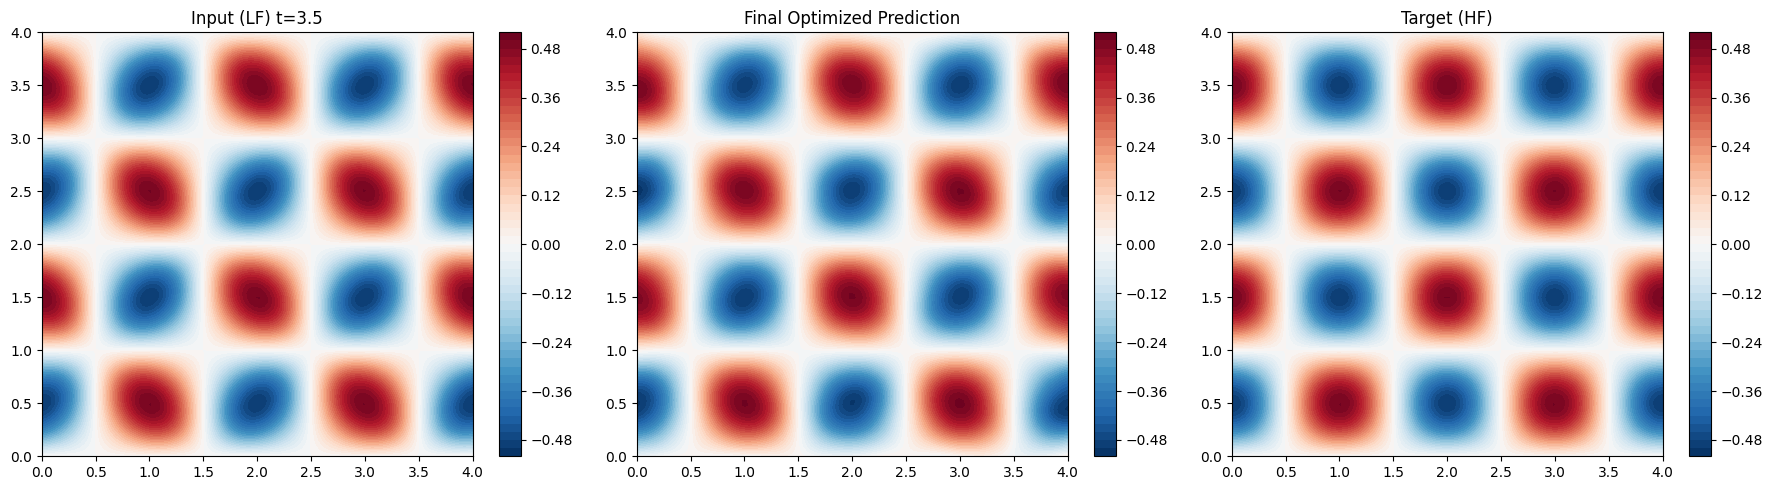

MSE (LF vs HF): 0.00030419
MSE (PINN vs HF): 0.00014168
최종 개선율: 53.42%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

def clear_memory():
    torch.cuda.empty_cache()

# ==========================================
# 1. 물리 식 정의 (정규화 및 체인 룰 반영)
# ==========================================
def get_pde_loss(model, x, y, t, nu, L=4.0, T=10.0):
    out = model(x, y, t)
    u, v, p = out[:, 0:1], out[:, 1:2], out[:, 2:3]
    def grad(outputs, inputs):
        return torch.autograd.grad(outputs, inputs, torch.ones_like(outputs), create_graph=True)[0]

    u_t = grad(u, t) / T
    v_t = grad(v, t) / T
    u_x_raw, u_y_raw = grad(u, x), grad(u, y)
    v_x_raw, v_y_raw = grad(v, x), grad(v, y)
    p_x_raw, p_y_raw = grad(p, x), grad(p, y)

    u_x, u_y, v_x, v_y, p_x, p_y = u_x_raw/L, u_y_raw/L, v_x_raw/L, v_y_raw/L, p_x_raw/L, p_y_raw/L
    u_xx, u_yy = grad(u_x_raw, x)/(L**2), grad(u_y_raw, y)/(L**2)
    v_xx, v_yy = grad(v_x_raw, x)/(L**2), grad(v_y_raw, y)/(L**2)

    f_mass = u_x + v_y
    f_u = u_t + (u*u_x + v*u_y) + p_x - nu*(u_xx + u_yy)
    f_v = v_t + (u*v_x + v*v_y) + p_y - nu*(v_xx + v_yy)

    return torch.mean(f_mass**2), torch.mean(f_u**2 + f_v**2)

# ==========================================
# 2. 학습 준비 및 베이스 격자 설정
# ==========================================
clear_memory()
model = PINN().to(device)
model.load_state_dict(torch.load("warmup_model.pth"))

# [검증된 설정] 서로소(Odd) 격자 베이스 설정 (메모리 안전권)
nt_p, nx_p, ny_p = 27, 41, 41
t_g = torch.linspace(0, 1, nt_p, device=device)
x_g = torch.linspace(0, 1, nx_p, device=device)
y_g = torch.linspace(0, 1, ny_p, device=device)
T_m, X_m, Y_m = torch.meshgrid(t_g, x_g, y_g, indexing='ij')

dt, dx, dy = 1.0/nt_p, 1.0/nx_p, 1.0/ny_p

# 규제를 강화한 Adam (초기 lr=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ==========================================
# 3. Phase 1: Adam 학습 (학습 시간 연장 및 LR Decay)
# ==========================================
print("\n--- Phase 1: Long-term Adam Training Start ---")
start_time = time.time()

# 에포크 10,000회로 연장
for epoch in range(5001):
    # [전략 2] Learning Rate Decay (5000 에포크 이후 lr 절반으로)
    if epoch == 5000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-5
        print("\n[LR Decay] Learning rate reduced to 5e-5")

    optimizer.zero_grad()

    # Dynamic Jittering
    T_p_dyn = T_m + (torch.rand_like(T_m) - 0.5) * dt
    X_p_dyn = X_m + (torch.rand_like(X_m) - 0.5) * dx
    Y_p_dyn = Y_m + (torch.rand_like(Y_m) - 0.5) * dy

    x_p = torch.clamp(X_p_dyn.reshape(-1, 1), 0, 1).requires_grad_(True)
    y_p = torch.clamp(Y_p_dyn.reshape(-1, 1), 0, 1).requires_grad_(True)
    t_p = torch.clamp(T_p_dyn.reshape(-1, 1), 0, 1).requires_grad_(True)

    # Loss 계산 (Data: 1.0, PDE: max 0.5)
    out = model(x_train, y_train, t_train)
    l_data = torch.mean((out[:,0:1]-u_train)**2 + (out[:,1:2]-v_train)**2 + (out[:,2:3]-p_train)**2)
    l_mass, l_mom = get_pde_loss(model, x_p, y_p, t_p, nu_val)

    # 가중치 스케줄링 (5000 에포크까지 서서히 증가 후 0.75 고정)
    pde_w = min(0.5 * (epoch/5000), 0.5)
    total_loss = 0.75 * l_data + pde_w * (l_mass + l_mom)

    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("-" * 40)
        elapsed = time.time() - start_time
        print(f"Ep {epoch:5d} | Total: {total_loss.item():.6f} | Time: {elapsed:.1f}s\n"
              f"       > Data: {l_data.item():.6f} | Mass: {l_mass.item():.6f} | Mom: {l_mom.item():.6f}")

# ==========================================
# 4. Phase 2: L-BFGS (강화된 정밀 최적화)
# ==========================================
print("\n--- Phase 2: Enhanced L-BFGS Refinement ---")
# [전략 3] max_iter를 2000으로 늘려 정밀하게 수렴
lbfgs = optim.LBFGS(model.parameters(),
                    max_iter=2000,
                    history_size=50,
                    line_search_fn="strong_wolfe")

def closure():
    lbfgs.zero_grad()
    out = model(x_train, y_train, t_train)
    ld = torch.mean((out[:,0:1]-u_train)**2 + (out[:,1:2]-v_train)**2 + (out[:,2:3]-p_train)**2)
    lm, lmo = get_pde_loss(model, x_p, y_p, t_p, nu_val)
    loss = 0.75 * ld + 0.2 * (lm + lmo) # 물리 법칙의 세밀한 교정
    if loss.requires_grad: loss.backward()
    return loss

lbfgs.step(closure)
clear_memory()

# ==========================================
# 5. 결과 시각화 및 오차 측정
# ==========================================
test_t = 3.5
X_g, Y_g, u_lf, _, _, u_hf, _, _ = generator.get_data_at_t(GRID, GRID, test_t)
x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_in = torch.tensor(np.full(x_in.shape, test_t/10.0), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(x_in, y_in, t_in)[:, 0].cpu().numpy().reshape(GRID, GRID)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1); plt.contourf(X_g, Y_g, u_lf, levels=50, cmap='RdBu_r'); plt.title(f"Input (LF) t={test_t}"); plt.colorbar()
plt.subplot(1, 3, 2); plt.contourf(X_g, Y_g, u_pred, levels=50, cmap='RdBu_r'); plt.title("Final Optimized Prediction"); plt.colorbar()
plt.subplot(1, 3, 3); plt.contourf(X_g, Y_g, u_hf, levels=50, cmap='RdBu_r'); plt.title("Target (HF)"); plt.colorbar()
plt.tight_layout(); plt.show()

mse_lf = np.mean((u_lf - u_hf)**2)
mse_pinn = np.mean((u_pred - u_hf)**2)
print(f"MSE (LF vs HF): {mse_lf:.8f}")
print(f"MSE (PINN vs HF): {mse_pinn:.8f}")
print(f"최종 개선율: {(mse_lf - mse_pinn)/mse_lf * 100:.2f}%")

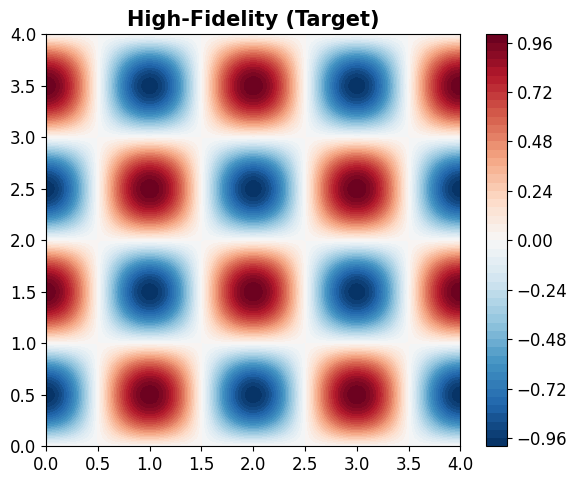

Saved: data_1_HF.png


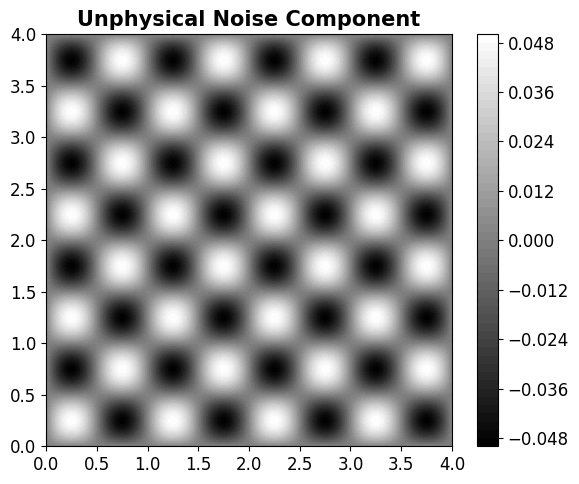

Saved: data_2_Noise.png


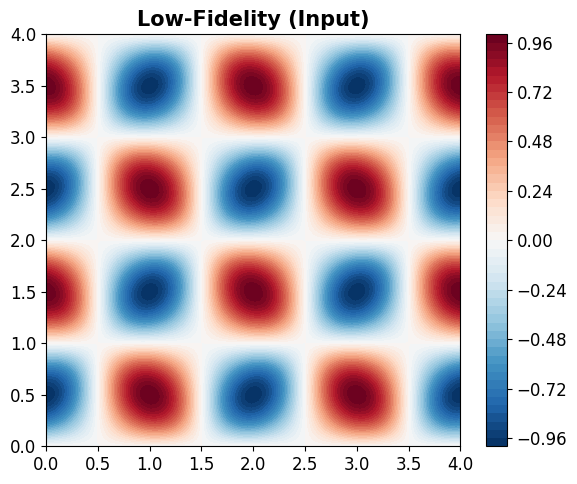

Saved: data_3_LF.png


In [ ]:
# ==========================================
# Slide 2용: 개별 이미지 저장 코드 (t=0 지점)
# ==========================================
import matplotlib.pyplot as plt

test_t = 0.0
X_g, Y_g, u_lf, _, _, u_hf, _, _ = generator.get_data_at_t(GRID, GRID, test_t)
u_noise = u_lf - u_hf

# 공통 폰트 설정
plt.rcParams.update({'font.size': 12})

# --- 1. High-Fidelity (Target) 저장 ---
plt.figure(figsize=(6, 5))
plt.contourf(X_g, Y_g, u_hf, levels=50, cmap='RdBu_r')
plt.title("High-Fidelity (Target)", fontsize=15, fontweight='bold')
plt.colorbar()
plt.tight_layout()
plt.savefig("data_1_HF.png", dpi=300)
plt.show()
print("Saved: data_1_HF.png")

# --- 2. Unphysical Noise 저장 ---
plt.figure(figsize=(6, 5))
plt.contourf(X_g, Y_g, u_noise, levels=50, cmap='gray')
plt.title("Unphysical Noise Component", fontsize=15, fontweight='bold')
plt.colorbar()
plt.tight_layout()
plt.savefig("data_2_Noise.png", dpi=300)
plt.show()
print("Saved: data_2_Noise.png")

# --- 3. Low-Fidelity (Input) 저장 ---
plt.figure(figsize=(6, 5))
plt.contourf(X_g, Y_g, u_lf, levels=50, cmap='RdBu_r')
plt.title("Low-Fidelity (Input)", fontsize=15, fontweight='bold')
plt.colorbar()
plt.tight_layout()
plt.savefig("data_3_LF.png", dpi=300)
plt.show()
print("Saved: data_3_LF.png")

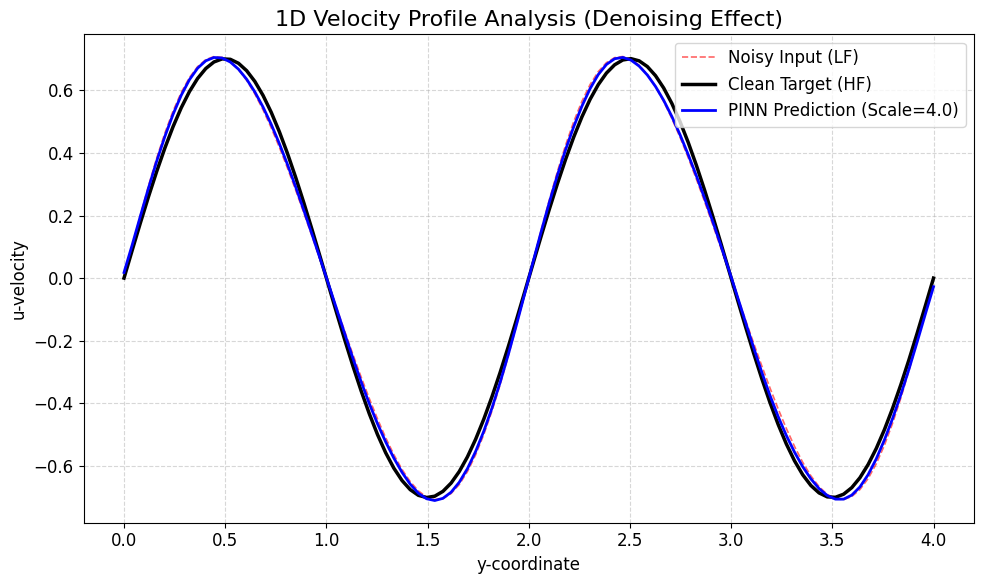

In [ ]:
# ==========================================
# Slide 3: Fourier Scale Analysis (Scale=4.0)
# ==========================================
test_t = 0.0 # 노이즈가 가장 잘 보이는 0초
X_g, Y_g, u_lf, _, _, u_hf, _, _ = generator.get_data_at_t(GRID, GRID, test_t)

# 모델 예측값 계산
x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_in = torch.tensor(np.full(x_in.shape, test_t/10.0), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(x_in, y_in, t_in)[:, 0].cpu().numpy().reshape(GRID, GRID)

# 단면 위치 선정 (노이즈가 강한 X=1.25 지점)
slice_idx = 31
y_line = np.linspace(0, L_val, GRID)

plt.figure(figsize=(10, 6))

# 1. Input LF (빨간 점선 - 지글지글한 노이즈)
plt.plot(y_line, u_lf[:, slice_idx], 'r--', alpha=0.6, linewidth=1.2, label='Noisy Input (LF)')

# 2. Target HF (검은 실선 - 우리가 가야 할 정답)
plt.plot(y_line, u_hf[:, slice_idx], 'k-', linewidth=2.5, label='Clean Target (HF)')

# 3. PINN Prediction (파란 실선 - 모델의 예측)
plt.plot(y_line, u_pred[:, slice_idx], 'b-', linewidth=2, label='PINN Prediction (Scale=4.0)')

plt.title(f"1D Velocity Profile Analysis (Denoising Effect)", fontsize=16)
plt.xlabel("y-coordinate", fontsize=12)
plt.ylabel("u-velocity", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, which='both', linestyle='--', alpha=0.5)


plt.tight_layout()
plt.savefig("slide3_denoising_effect.png", dpi=300)
plt.show()

In [ ]:
import numpy as np

def get_relative_l2_error(pred, true):
    return np.linalg.norm(pred - true) / (np.linalg.norm(true) + 1e-10)

def get_mse(pred, true):
    return np.mean((pred - true)**2)

 Time |     MSE (PINN vs HF) |   Rel. L2 Error
--------------------------------------------------
  2.5 |           0.00014111 |        0.038918


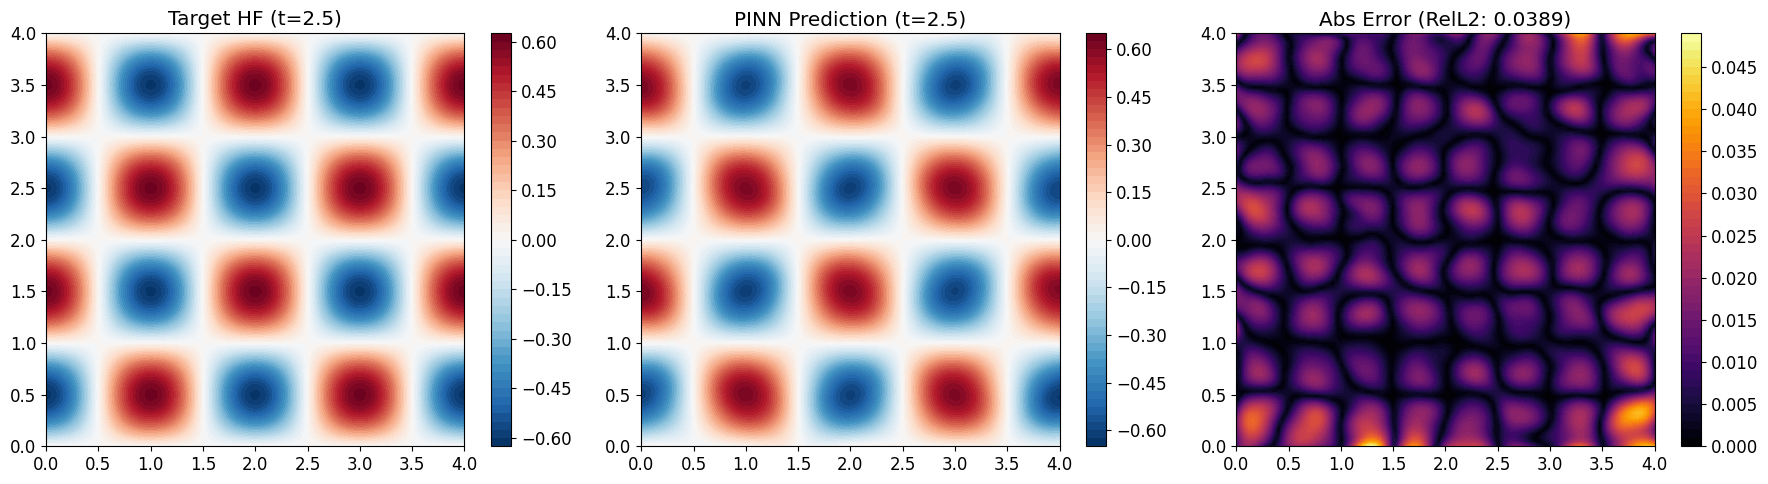

Saved: result_t_2.5.png
  7.5 |           0.00010497 |        0.090061


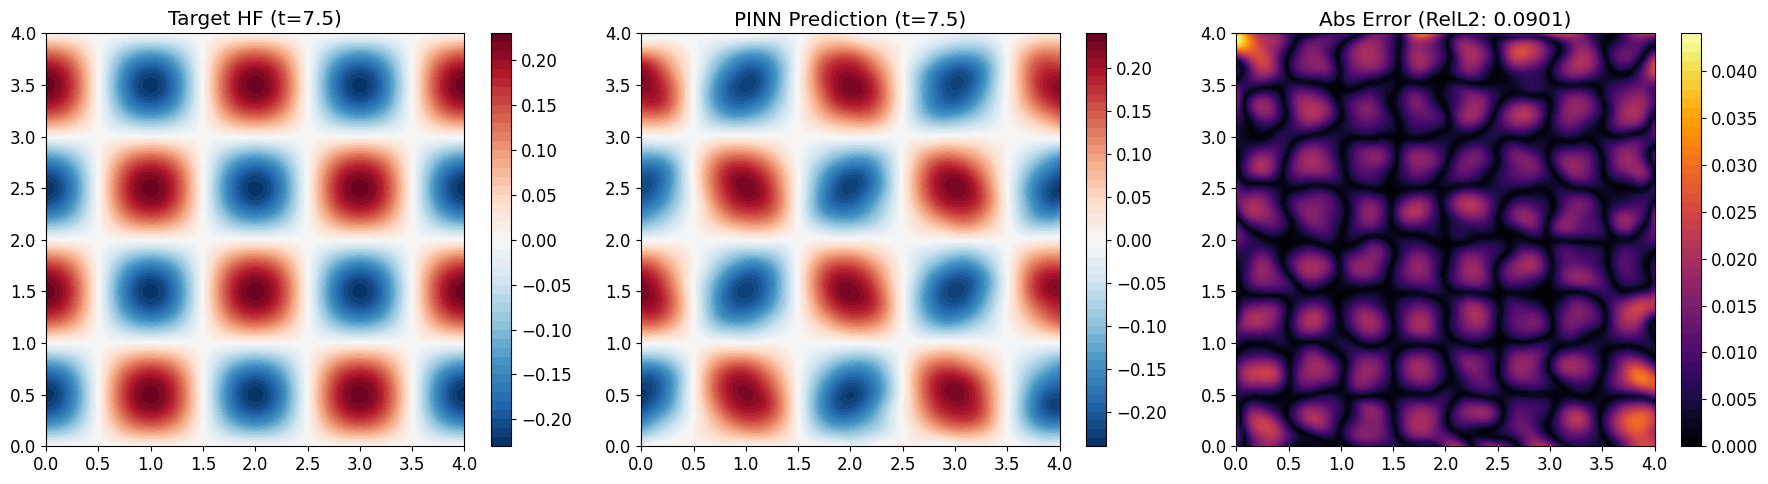

Saved: result_t_7.5.png


In [ ]:
# ==========================================
# [세 번째 셀] t=2.5, 7.5 (중간 지점 내삽)
# ==========================================
eval_times_3 = [2.5, 7.5]

print(f"{'Time':>5} | {'MSE (PINN vs HF)':>20} | {'Rel. L2 Error':>15}")
print("-" * 50)

for t_val in eval_times_3:
    X_g, Y_g, _, _, _, u_hf, _, _ = generator.get_data_at_t(GRID, GRID, t_val)

    # 모델 입력 (정규화 t/10)
    x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_in = torch.tensor(np.full(x_in.shape, t_val/10.0), dtype=torch.float32).view(-1, 1).to(device)

    model.eval()
    with torch.no_grad():
        u_pred = model(x_in, y_in, t_in)[:, 0].cpu().numpy().reshape(GRID, GRID)

    mse = get_mse(u_pred, u_hf)
    l2_error = get_relative_l2_error(u_pred, u_hf)
    print(f"{t_val:5.1f} | {mse:20.8f} | {l2_error:15.6f}")

    # 개별 시간당 하나의 figure 생성 (1행 3열)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Target HF
    im0 = axes[0].contourf(X_g, Y_g, u_hf, levels=50, cmap='RdBu_r')
    axes[0].set_title(f"Target HF (t={t_val})")
    plt.colorbar(im0, ax=axes[0])

    # 2. PINN Prediction
    im1 = axes[1].contourf(X_g, Y_g, u_pred, levels=50, cmap='RdBu_r')
    axes[1].set_title(f"PINN Prediction (t={t_val})")
    plt.colorbar(im1, ax=axes[1])

    # 3. Absolute Error
    im2 = axes[2].contourf(X_g, Y_g, np.abs(u_pred - u_hf), levels=50, cmap='inferno')
    axes[2].set_title(f"Abs Error (RelL2: {l2_error:.4f})")
    plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    # 파일 저장 (예: result_t_2.5.png)
    plt.savefig(f"result_t_{t_val}.png", dpi=300)
    plt.show()
    print(f"Saved: result_t_{t_val}.png")

 Time |     MSE (PINN vs HF) |   Rel. L2 Error
--------------------------------------------------
 1.25 |           0.00017575 |        0.033936


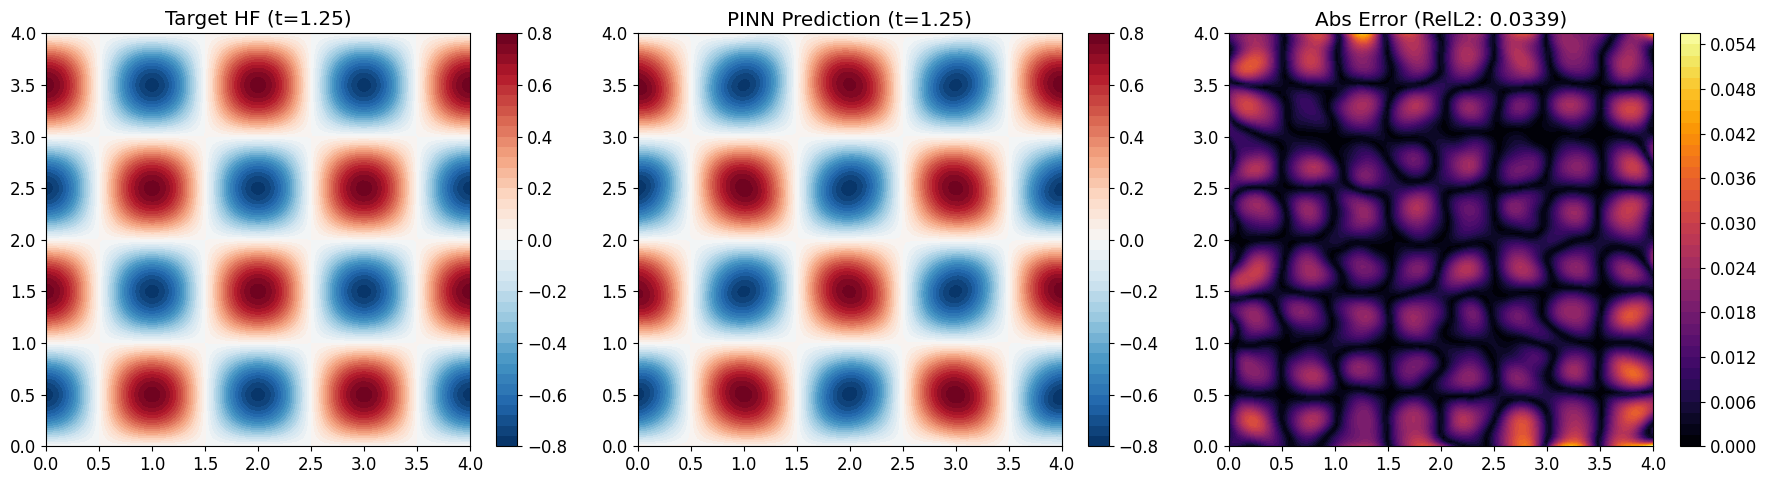

Saved: result_t_1.25.png
 7.75 |           0.00009842 |        0.091617


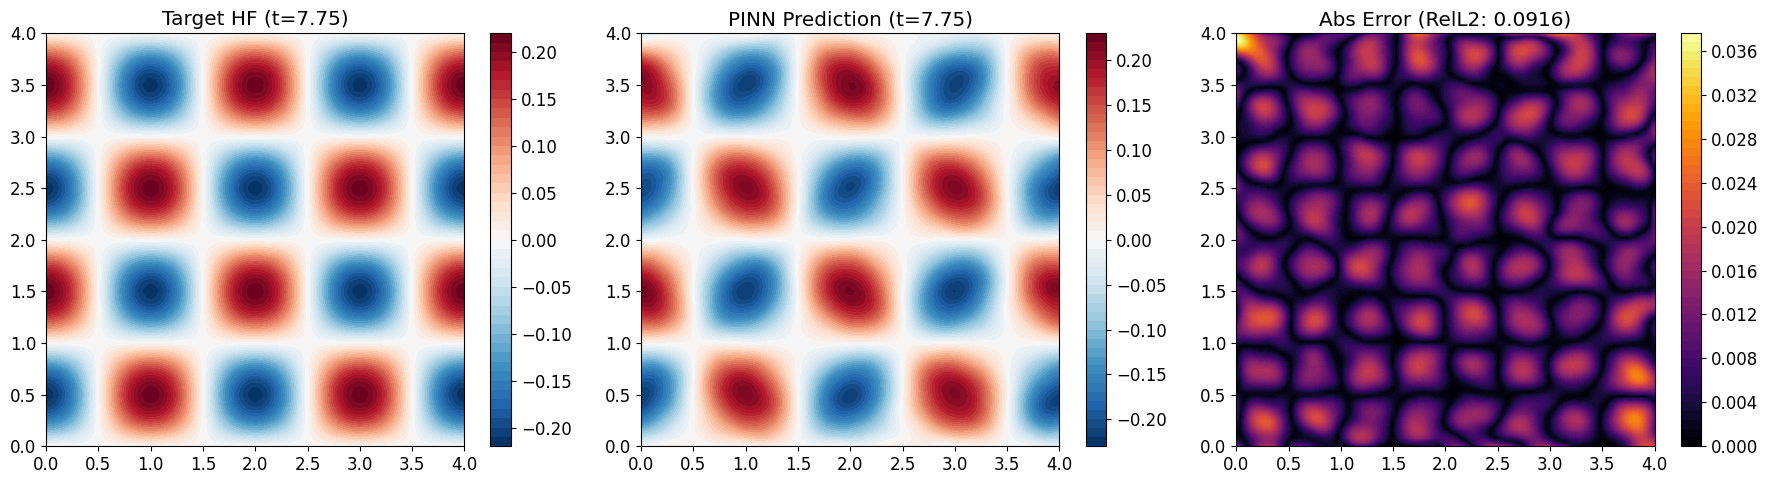

Saved: result_t_7.75.png


In [ ]:
# ==========================================
# [네 번째 셀] t=1.25, 7.75 (비대칭 내삽)
# ==========================================
eval_times_4 = [1.25, 7.75]

print(f"{'Time':>5} | {'MSE (PINN vs HF)':>20} | {'Rel. L2 Error':>15}")
print("-" * 50)

for t_val in eval_times_4:
    X_g, Y_g, _, _, _, u_hf, _, _ = generator.get_data_at_t(GRID, GRID, t_val)
    x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_in = torch.tensor(np.full(x_in.shape, t_val/10.0), dtype=torch.float32).view(-1, 1).to(device)

    model.eval()
    with torch.no_grad():
        u_pred = model(x_in, y_in, t_in)[:, 0].cpu().numpy().reshape(GRID, GRID)

    mse = get_mse(u_pred, u_hf)
    l2_error = get_relative_l2_error(u_pred, u_hf)
    print(f"{t_val:5.2f} | {mse:20.8f} | {l2_error:15.6f}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axes[0].contourf(X_g, Y_g, u_hf, levels=50, cmap='RdBu_r'); axes[0].set_title(f"Target HF (t={t_val})"); plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].contourf(X_g, Y_g, u_pred, levels=50, cmap='RdBu_r'); axes[1].set_title(f"PINN Prediction (t={t_val})"); plt.colorbar(im1, ax=axes[1])
    im2 = axes[2].contourf(X_g, Y_g, np.abs(u_pred - u_hf), levels=50, cmap='inferno'); axes[2].set_title(f"Abs Error (RelL2: {l2_error:.4f})"); plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.savefig(f"result_t_{t_val}.png", dpi=300)
    plt.show()
    print(f"Saved: result_t_{t_val}.png")

 Time |     MSE (PINN vs HF) |   Rel. L2 Error
--------------------------------------------------
 10.5 |           0.00264674 |        0.817587


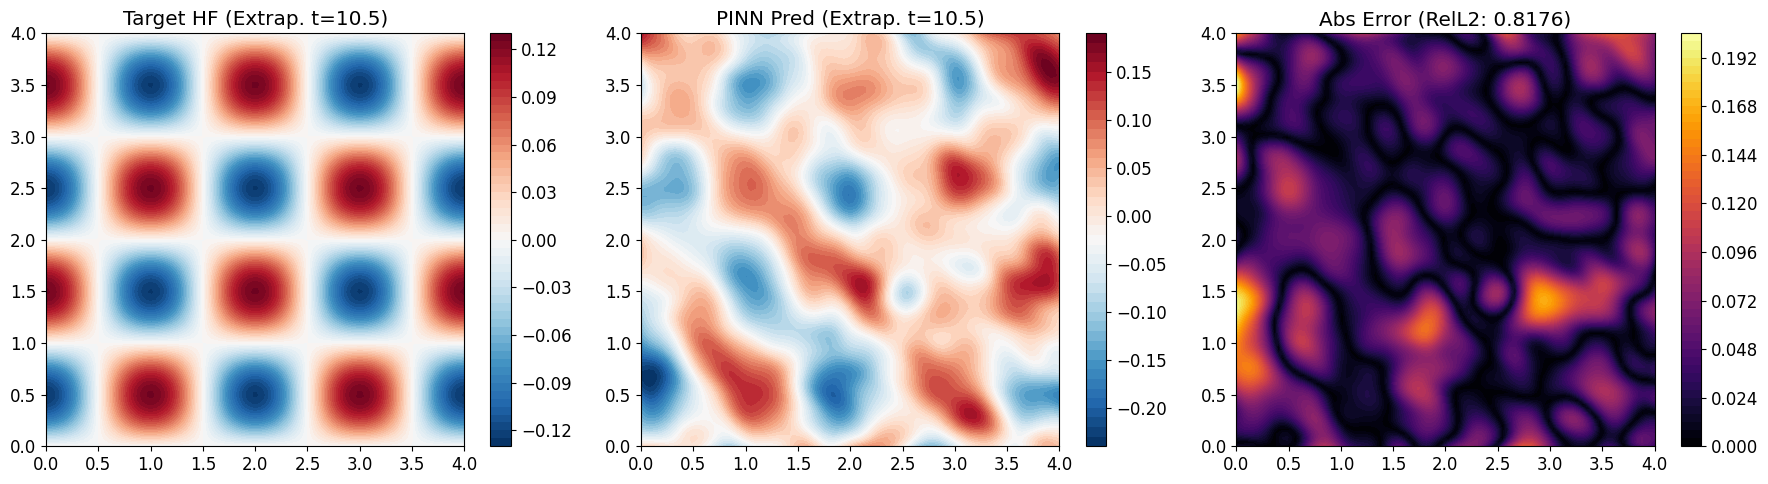

Saved: result_t_10.5.png
 11.0 |           0.01989564 |        2.474115


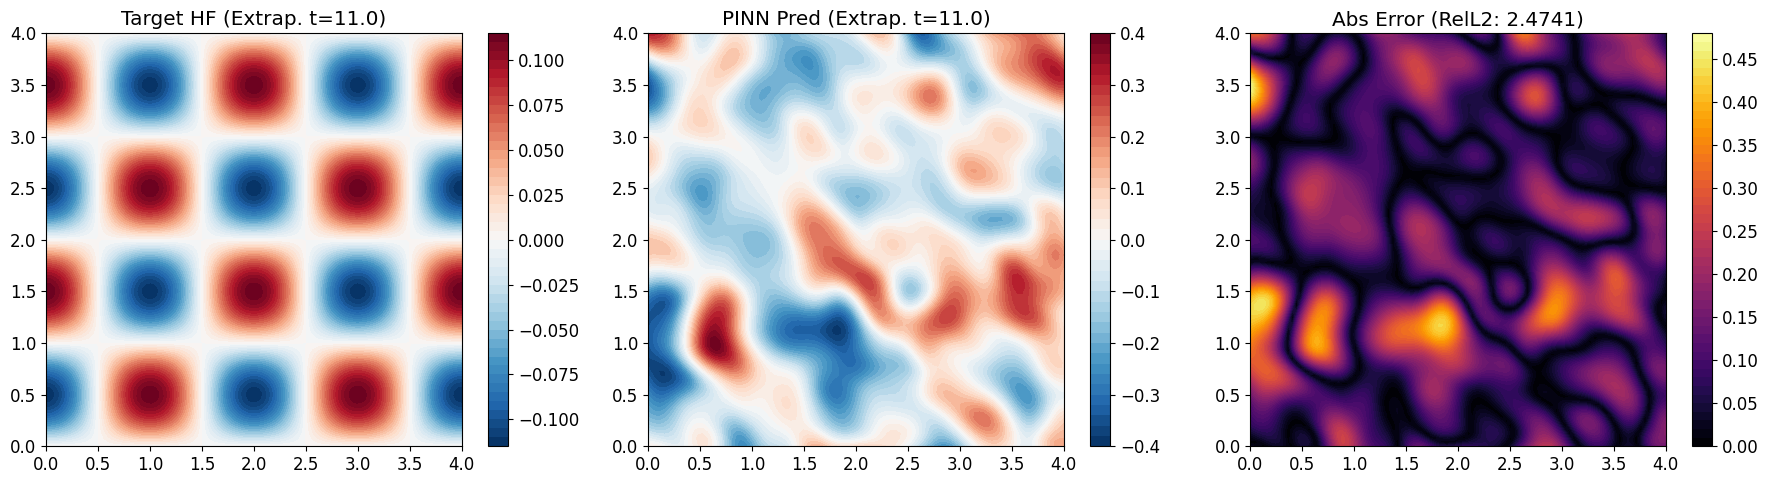

Saved: result_t_11.0.png


In [ ]:
# ==========================================
# [다섯 번째 셀] t=10.5, 11.0 (외삽 - 미래 예측)
# ==========================================
eval_times_5 = [10.5, 11.0]

print(f"{'Time':>5} | {'MSE (PINN vs HF)':>20} | {'Rel. L2 Error':>15}")
print("-" * 50)

for t_val in eval_times_5:
    X_g, Y_g, _, _, _, u_hf, _, _ = generator.get_data_at_t(GRID, GRID, t_val)
    x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_in = torch.tensor(np.full(x_in.shape, t_val/10.0), dtype=torch.float32).view(-1, 1).to(device)

    model.eval()
    with torch.no_grad():
        u_pred = model(x_in, y_in, t_in)[:, 0].cpu().numpy().reshape(GRID, GRID)

    mse = get_mse(u_pred, u_hf)
    l2_error = get_relative_l2_error(u_pred, u_hf)
    print(f"{t_val:5.1f} | {mse:20.8f} | {l2_error:15.6f}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axes[0].contourf(X_g, Y_g, u_hf, levels=50, cmap='RdBu_r'); axes[0].set_title(f"Target HF (Extrap. t={t_val})"); plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].contourf(X_g, Y_g, u_pred, levels=50, cmap='RdBu_r'); axes[1].set_title(f"PINN Pred (Extrap. t={t_val})"); plt.colorbar(im1, ax=axes[1])
    im2 = axes[2].contourf(X_g, Y_g, np.abs(u_pred - u_hf), levels=50, cmap='inferno'); axes[2].set_title(f"Abs Error (RelL2: {l2_error:.4f})"); plt.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.savefig(f"result_t_{t_val}.png", dpi=300)
    plt.show()
    print(f"Saved: result_t_{t_val}.png")

In [ ]:
import os
import zipfile
from IPython.display import FileLink

# 1. 압축 파일 이름 설정
zip_filename = 'all_results_images.zip'

# 2. 압축 파일 생성
with zipfile.ZipFile(zip_filename, 'w') as zip_f:
    # 현재 작업 디렉토리의 모든 파일을 확인
    for root, dirs, files in os.walk('/kaggle/working'):
        for file in files:
            # 이미지 파일(.png, .jpg)만 골라 담기 (압축파일 자체는 제외)
            if (file.endswith('.png') or file.endswith('.jpg')) and file != zip_filename:
                zip_f.write(os.path.join(root, file), file)

print(f"--- 압축 완료: {zip_filename} ---")

# 3. 다운로드 링크 출력
FileLink(zip_filename)

--- 압축 완료: all_results_images.zip ---


/kaggle/working/all_results_images.zip